In [ ]:
import torch
import torch.nn as nn

class SimpleCNN(nn.Module):

    
    def __init__(self, output_size):

        super(SimpleCNN, self).__init__()
        
        # This block will take the [1, 28, 28] input image
        self.conv_block1 = nn.Sequential(
            # nn.Conv2d(in_channels, out_channels, kernel_size)
            # in_channels=1 because MNIST images are grayscale
            # out_channels=16 means we are creating 16 "feature maps"
            # kernel_size=3 means we're using a 3x3 filter
            # padding=1 ensures the 28x28 image remains 28x28 after convolution
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size)
            # kernel_size=2 means we take a 2x2 window and keep the max value
            # This will reduce the image size from [16, 28, 28] to [16, 14, 14]
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # --- 2. Convolutional Block 2 ---
        # This block will take the [16, 14, 14] feature maps
        self.conv_block2 = nn.Sequential(
            # in_channels=16 (must match out_channels from block 1)
            # out_channels=32 means we're creating 32 new feature maps
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            # This will reduce the feature maps from [32, 14, 14] to [32, 7, 7]
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Now we need to flatten the [32, 7, 7] output from conv_block2
        # The size is 32 * 7 * 7 = 1568
        self.classifier = nn.Sequential(
            nn.Linear(32 * 7 * 7, 128), # Input 1568, output 128
            nn.ReLU(),
            nn.Linear(128, output_size)  # Input 128, output 10
        )


    def forward(self, x):
        """
        Defines the forward pass.
        
        Args:
            x (Tensor): Input batch of images. 
                        Shape must be [batch_size, 1, 28, 28]
        """
        # Pass through [Conv -> ReLU -> Pool] block 1
        x = self.conv_block1(x)
        
        # Pass through [Conv -> ReLU -> Pool] block 2
        x = self.conv_block2(x)
        
        # x's current shape is [batch_size, 32, 7, 7]
        # We need to reshape it to [batch_size, 1568]
        # The .view() method does this. -1 tells PyTorch to
        # automatically calculate the batch size.
        x = x.view(-1, 32 * 7 * 7)
        
        # Pass through the classifier [FC -> ReLU] -> [FC]
        logits = self.classifier(x)
        
        return logits


cnn_model = SimpleCNN(output_size=10)

device = "cuda" if torch.cuda.is_available() else "cpu"
cnn_model = cnn_model.to(device)

print(cnn_model)



SimpleCNN(
  (conv_block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=1568, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)

Shape of output: torch.Size([64, 10])


In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn

# Define the CNN-specific transformations
# This pipeline does NOT flatten the images.
# It produces 4D tensors: [batch_size, 1, 28, 28]

transform_pipeline_cnn = transforms.Compose([
    

    transforms.ToTensor(),
    
    transforms.Normalize((0.1307,), (0.3081,)),
    
    # *** NO FLATTEN STEP ***
])



train_dataset_cnn = datasets.MNIST(
    root='./data',     
    train=True,         
    download=True,     
    transform=transform_pipeline_cnn 
)

val_dataset_cnn = datasets.MNIST(
    root='./data',
    train=False,       
    download=True,
    transform=transform_pipeline_cnn
)

BATCH_SIZE = 64 
train_loader_cnn = DataLoader(
    dataset=train_dataset_cnn,
    batch_size=BATCH_SIZE,
    shuffle=True  
)

val_loader_cnn = DataLoader(
    dataset=val_dataset_cnn,
    batch_size=BATCH_SIZE,
    shuffle=False 
)


print(f"--- CNN DataLoaders Created ---")
print(f"Total training samples: {len(train_dataset_cnn)}")
print(f"Total validation samples: {len(val_dataset_cnn)}")


# This confirms our data is correctly shaped for the CNN model
X_batch_example, y_batch_example = next(iter(train_loader_cnn))

print(f"\nExample batch shapes:")
print(f"X_batch shape: {X_batch_example.shape}") # Should be [64, 1, 28, 28]
print(f"y_batch shape: {y_batch_example.shape}") # Should be [64]



--- CNN DataLoaders Created ---
Total training samples: 60000
Total validation samples: 10000

Example batch shapes:
X_batch shape: torch.Size([64, 1, 28, 28])
y_batch shape: torch.Size([64])


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import time
import numpy as np

def train_model_with_early_stopping(model, criterion, optimizer, train_loader, val_loader, 
                                    num_epochs, patience, save_path, device):

    
    print(f"Starting training for {num_epochs} epochs on {device}...")
    print(f"Early stopping enabled with patience = {patience}")
    start_time = time.time()
    
    # Dictionaries to store the metrics for plotting
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    # Early Stopping variables 
    best_val_loss = np.inf
    patience_counter = 0
    best_epoch = 0


    for epoch in range(num_epochs):
        
        # Training Phase
        model.train() 
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_train_loss = running_train_loss / total_train
        epoch_train_acc = 100 * correct_train / total_train
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)

        
        # Validation Phase
        model.eval() 
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                running_val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_val_loss / total_val
        epoch_val_acc = 100 * correct_val / total_val
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)
        
        
        # Log Progress & Early Stop Check 
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.2f}%")
        
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            patience_counter = 0
            best_epoch = epoch + 1
            torch.save(model.state_dict(), save_path)
            print(f"   -> New best model saved! Val Loss: {best_val_loss:.4f}")
        else:
            patience_counter += 1
            print(f"   -> No improvement. Patience: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print(f"\n--- Early stopping triggered at epoch {epoch+1} ---")
                break 

    end_time = time.time()
    print(f"\nTraining finished in {(end_time - start_time):.2f} seconds.")
    
    print(f"Loading best model from epoch {best_epoch} (Val Loss: {best_val_loss:.4f})")
    model.load_state_dict(torch.load(save_path))
    
    return history

LEARNING_RATE = 0.01
NUM_EPOCHS = 50    
PATIENCE = 5      
BEST_MODEL_PATH = "best_cnn_model.pth" 

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"--- Using {device} device ---")



cnn_model = SimpleCNN(output_size=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_model.parameters(), lr=LEARNING_RATE)

print("\n Starting CNN Model Training ")


cnn_history = train_model_with_early_stopping(
    cnn_model, 
    criterion, 
    optimizer, 
    train_loader_cnn,  # new CNN loaders
    val_loader_cnn,    # new CNN loaders
    NUM_EPOCHS, 
    PATIENCE, 
    BEST_MODEL_PATH, 
    device
)

print("\nCNN Training complete!")
print(f"Final Validation Accuracy: {cnn_history['val_acc'][-1]:.2f}%")

--- Using cpu device ---

--- Starting CNN Model Training ---
Starting training for 50 epochs on cpu...
Early stopping enabled with patience = 5
Epoch 1/50 | Val Loss: 0.2976 | Val Acc: 90.09%
   -> New best model saved! Val Loss: 0.2976
Epoch 2/50 | Val Loss: 0.1210 | Val Acc: 96.26%
   -> New best model saved! Val Loss: 0.1210
Epoch 3/50 | Val Loss: 0.0896 | Val Acc: 97.41%
   -> New best model saved! Val Loss: 0.0896
Epoch 4/50 | Val Loss: 0.0676 | Val Acc: 97.83%
   -> New best model saved! Val Loss: 0.0676
Epoch 5/50 | Val Loss: 0.0791 | Val Acc: 97.46%
   -> No improvement. Patience: 1/5
Epoch 6/50 | Val Loss: 0.0657 | Val Acc: 97.91%
   -> New best model saved! Val Loss: 0.0657
Epoch 7/50 | Val Loss: 0.0580 | Val Acc: 98.09%
   -> New best model saved! Val Loss: 0.0580
Epoch 8/50 | Val Loss: 0.0436 | Val Acc: 98.55%
   -> New best model saved! Val Loss: 0.0436
Epoch 9/50 | Val Loss: 0.0540 | Val Acc: 98.26%
   -> No improvement. Patience: 1/5
Epoch 10/50 | Val Loss: 0.0406 | Val

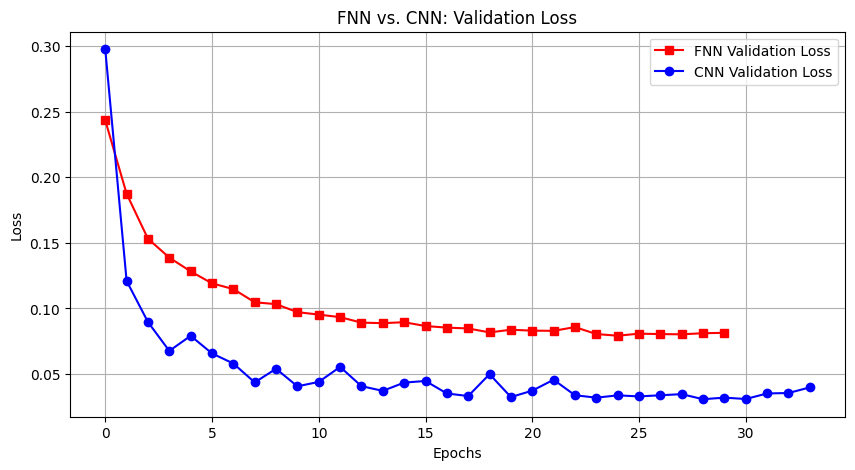

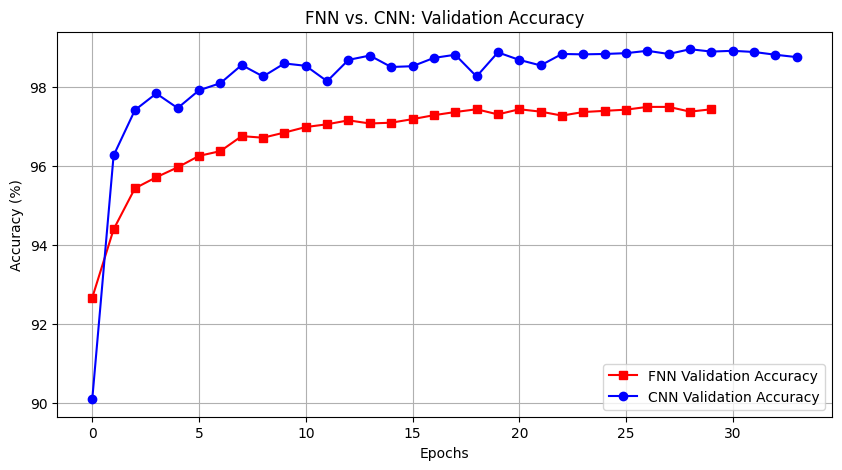

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# (Copied From Part B)
fnn_history = {'train_loss': [0.4408403079032898, 0.2160606868783633, 0.17018077589670816, 0.14372837900916735, 0.1254635875125726, 0.11186255576014519, 0.10058877486089865, 0.09168068054219088, 0.08405347805817923, 0.07735553481429815, 0.07160521099915107, 0.06644156880527735, 0.06207042988936106, 0.05777990523477396, 0.053720705637335775, 0.050542102286219595, 0.04736869153231382, 0.044192587452133496, 0.041613623874882856, 0.039182923687249425, 0.03687621327750385, 0.0348482533827424, 0.03271473772674799, 0.03078959790406128, 0.02901118614859879, 0.027376159440601865, 0.025763626096459727, 0.024588496736064554, 0.02310993256829679, 0.0217641002861162], 'train_acc': [86.865, 93.65, 95.03166666666667, 95.775, 96.27833333333334, 96.69833333333334, 97.08, 97.32, 97.54666666666667, 97.73333333333333, 97.90333333333334, 98.09, 98.23666666666666, 98.335, 98.525, 98.59, 98.70333333333333, 98.86, 98.91333333333333, 99.01666666666667, 99.05333333333333, 99.12833333333333, 99.20833333333333, 99.275, 99.32166666666667, 99.37166666666667, 99.44333333333333, 99.49666666666667, 99.525, 99.57166666666667], 'val_loss': [0.24338268975317479, 0.18739516005516052, 0.15311104222089053, 0.13875342285633088, 0.12823044219911098, 0.11911284991875291, 0.11474674552157521, 0.10470167536213994, 0.10325485996864736, 0.09716617517583072, 0.09530278252363204, 0.09333759046923369, 0.0891761597942561, 0.08876197490356863, 0.08948915149830282, 0.0865793776630424, 0.08537614553216845, 0.08473154009552672, 0.08173416305566207, 0.0837619528574869, 0.08306195639804936, 0.08292528604506515, 0.08576766837188042, 0.0804711264686659, 0.07920114974523894, 0.08076261387369596, 0.08044807641408407, 0.08025942215844989, 0.08109771780110896, 0.08140876687269193], 'val_acc': [92.66, 94.39, 95.43, 95.71, 95.96, 96.25, 96.37, 96.75, 96.71, 96.84, 96.98, 97.05, 97.15, 97.07, 97.09, 97.18, 97.28, 97.36, 97.43, 97.3, 97.43, 97.37, 97.27, 97.36, 97.39, 97.42, 97.49, 97.49, 97.37, 97.43]}

if len(fnn_history) == 0:
    print("ERROR: Please paste 'fnn_history' dictionary into this cell.")
else:
    # --- Plot 1: Validation Loss Comparison ---
    plt.figure(figsize=(10, 5))
    plt.plot(fnn_history['val_loss'], 'r-s', label='FNN Validation Loss')
    plt.plot(cnn_history['val_loss'], 'b-o', label='CNN Validation Loss')
    plt.title('FNN vs. CNN: Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Plot 2: Validation Accuracy Comparison ---
    plt.figure(figsize=(10, 5))
    plt.plot(fnn_history['val_acc'], 'r-s', label='FNN Validation Accuracy')
    plt.plot(cnn_history['val_acc'], 'b-o', label='CNN Validation Accuracy')
    plt.title('FNN vs. CNN: Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
class CNN_With_Dropout(nn.Module):
    """
    A SimpleCNN model modified to include Dropout
    in the classifier section.
    """
    
    def __init__(self, output_size, dropout_rate=0.5):
        """
        Initializes layers, including a Dropout layer.
        
        Args:
            output_size (int): Number of output classes (10)
            dropout_rate (float): The probability of dropping out a neuron (p)
        """
        super(CNN_With_Dropout, self).__init__()
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(),
            

            nn.Dropout(p=dropout_rate), 
            
            nn.Linear(128, output_size)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = x.view(-1, 32 * 7 * 7)
        logits = self.classifier(x)
        return logits

In [ ]:
dropout_rates = [0.1, 0.3, 0.5, 0.7]
all_dropout_histories = {} 

LEARNING_RATE = 0.01
NUM_EPOCHS = 50
PATIENCE = 5
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"--- Starting Dropout Experiment on {device} ---")

for rate in dropout_rates:
    print(f"\n--- Training with dropout rate: {rate} ---")
    
    model = CNN_With_Dropout(output_size=10, dropout_rate=rate).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
    
    save_path = f"best_cnn_dropout_{rate}.pth"
    
    history = train_model_with_early_stopping(
        model, 
        criterion, 
        optimizer, 
        train_loader_cnn,
        val_loader_cnn,
        NUM_EPOCHS, 
        PATIENCE, 
        save_path, 
        device
    )
    
    # Store the history
    all_dropout_histories[rate] = history

print("\n--- Dropout Experiment Complete ---")

--- Starting Dropout Experiment on cpu ---

--- Training with dropout rate: 0.1 ---
Starting training for 50 epochs on cpu...
Early stopping enabled with patience = 5
Epoch 1/50 | Val Loss: 0.2246 | Val Acc: 93.22%
   -> New best model saved! Val Loss: 0.2246
Epoch 2/50 | Val Loss: 0.1109 | Val Acc: 96.50%
   -> New best model saved! Val Loss: 0.1109
Epoch 3/50 | Val Loss: 0.0895 | Val Acc: 97.29%
   -> New best model saved! Val Loss: 0.0895
Epoch 4/50 | Val Loss: 0.0687 | Val Acc: 97.84%
   -> New best model saved! Val Loss: 0.0687
Epoch 5/50 | Val Loss: 0.0604 | Val Acc: 98.07%
   -> New best model saved! Val Loss: 0.0604
Epoch 6/50 | Val Loss: 0.0559 | Val Acc: 98.25%
   -> New best model saved! Val Loss: 0.0559
Epoch 7/50 | Val Loss: 0.0493 | Val Acc: 98.42%
   -> New best model saved! Val Loss: 0.0493
Epoch 8/50 | Val Loss: 0.0493 | Val Acc: 98.28%
   -> New best model saved! Val Loss: 0.0493
Epoch 9/50 | Val Loss: 0.0411 | Val Acc: 98.61%
   -> New best model saved! Val Loss: 0.0

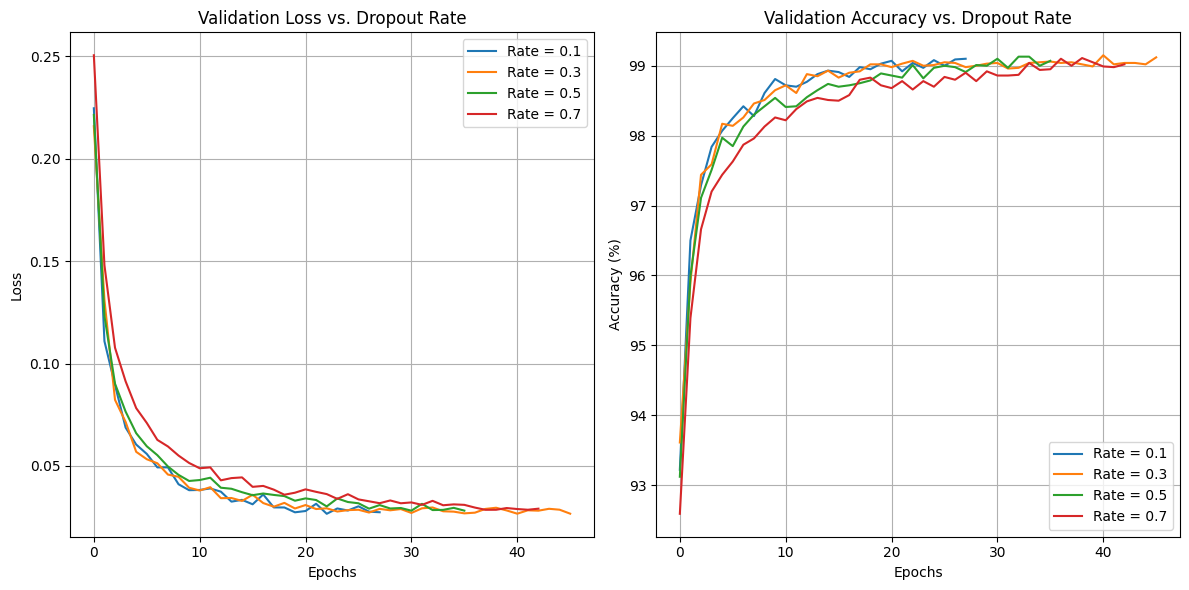

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# --- Plot 1: Validation Loss ---
plt.subplot(1, 2, 1) # 1 row, 2 cols, plot 1
for rate, history in all_dropout_histories.items():
    plt.plot(history['val_loss'], label=f'Rate = {rate}')
plt.title('Validation Loss vs. Dropout Rate')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# --- Plot 2: Validation Accuracy ---
plt.subplot(1, 2, 2) # 1 row, 2 cols, plot 2
for rate, history in all_dropout_histories.items():
    plt.plot(history['val_acc'], label=f'Rate = {rate}')
plt.title('Validation Accuracy vs. Dropout Rate')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
class CNN_With_BatchNorm(nn.Module):

    def __init__(self, output_size):
        super(CNN_With_BatchNorm, self).__init__()
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),

            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(32 * 7 * 7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            # No BN needed before the final output layer
            nn.Linear(128, output_size)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = x.view(-1, 32 * 7 * 7)
        logits = self.classifier(x)
        return logits

In [ ]:

print(f"--- Starting Batch Normalization Experiment on {device} ---")

model_bn = CNN_With_BatchNorm(output_size=10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_bn.parameters(), lr=LEARNING_RATE)

save_path = "best_cnn_batchnorm.pth"

bn_history = train_model_with_early_stopping(
    model_bn, 
    criterion, 
    optimizer, 
    train_loader_cnn,
    val_loader_cnn,
    NUM_EPOCHS, 
    PATIENCE, 
    save_path, 
    device
)

print("\n--- Batch Normalization Experiment Complete ---")

--- Starting Batch Normalization Experiment on cpu ---
Starting training for 50 epochs on cpu...
Early stopping enabled with patience = 5
Epoch 1/50 | Val Loss: 0.1047 | Val Acc: 97.75%
   -> New best model saved! Val Loss: 0.1047
Epoch 2/50 | Val Loss: 0.0646 | Val Acc: 98.42%
   -> New best model saved! Val Loss: 0.0646
Epoch 3/50 | Val Loss: 0.0533 | Val Acc: 98.61%
   -> New best model saved! Val Loss: 0.0533
Epoch 4/50 | Val Loss: 0.0464 | Val Acc: 98.76%
   -> New best model saved! Val Loss: 0.0464
Epoch 5/50 | Val Loss: 0.0446 | Val Acc: 98.75%
   -> New best model saved! Val Loss: 0.0446
Epoch 6/50 | Val Loss: 0.0410 | Val Acc: 98.87%
   -> New best model saved! Val Loss: 0.0410
Epoch 7/50 | Val Loss: 0.0373 | Val Acc: 98.88%
   -> New best model saved! Val Loss: 0.0373
Epoch 8/50 | Val Loss: 0.0367 | Val Acc: 98.89%
   -> New best model saved! Val Loss: 0.0367
Epoch 9/50 | Val Loss: 0.0333 | Val Acc: 99.03%
   -> New best model saved! Val Loss: 0.0333
Epoch 10/50 | Val Loss: 0

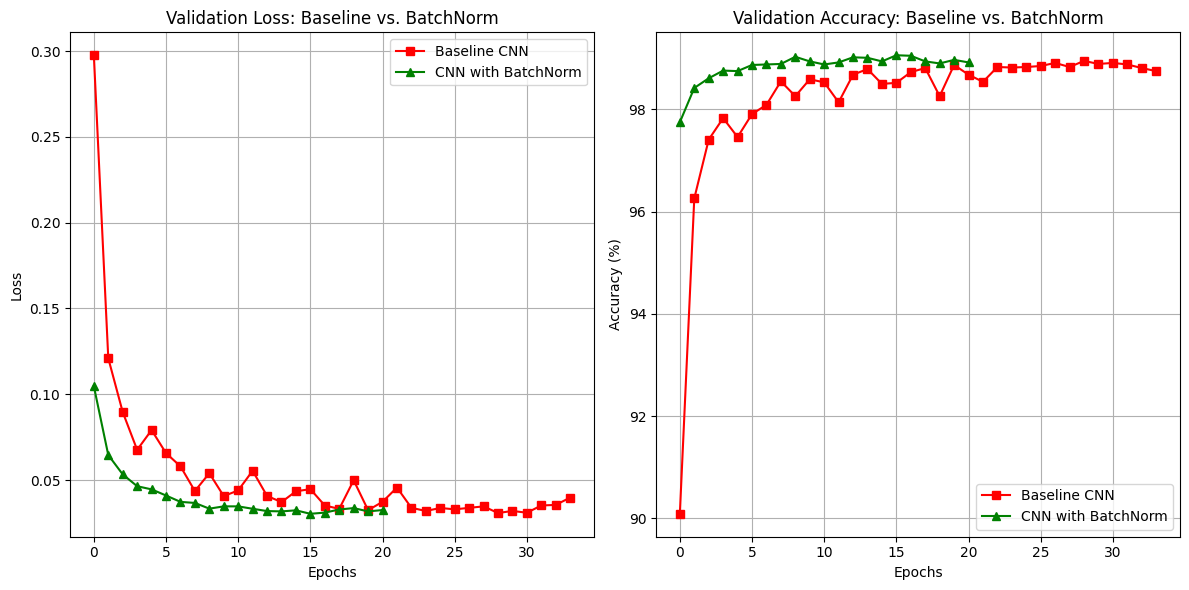

In [19]:

plt.figure(figsize=(12, 6))

# --- Plot 1: Validation Loss ---
plt.subplot(1, 2, 1)
plt.plot(cnn_history['val_loss'], 'r-s', label='Baseline CNN')
plt.plot(bn_history['val_loss'], 'g-^', label='CNN with BatchNorm')
plt.title('Validation Loss: Baseline vs. BatchNorm')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# --- Plot 2: Validation Accuracy ---
plt.subplot(1, 2, 2)
plt.plot(cnn_history['val_acc'], 'r-s', label='Baseline CNN')
plt.plot(bn_history['val_acc'], 'g-^', label='CNN with BatchNorm')
plt.title('Validation Accuracy: Baseline vs. BatchNorm')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


--- Starting Combined (BN + Dropout) Experiment ---
Starting training for 50 epochs on cpu...
Early stopping enabled with patience = 5
Epoch 1/50 | Val Loss: 0.1031 | Val Acc: 97.71%
   -> New best model saved! Val Loss: 0.1031
Epoch 2/50 | Val Loss: 0.0676 | Val Acc: 98.22%
   -> New best model saved! Val Loss: 0.0676
Epoch 3/50 | Val Loss: 0.0531 | Val Acc: 98.58%
   -> New best model saved! Val Loss: 0.0531
Epoch 4/50 | Val Loss: 0.0485 | Val Acc: 98.65%
   -> New best model saved! Val Loss: 0.0485
Epoch 5/50 | Val Loss: 0.0482 | Val Acc: 98.67%
   -> New best model saved! Val Loss: 0.0482
Epoch 6/50 | Val Loss: 0.0382 | Val Acc: 98.82%
   -> New best model saved! Val Loss: 0.0382
Epoch 7/50 | Val Loss: 0.0382 | Val Acc: 98.77%
   -> No improvement. Patience: 1/5
Epoch 8/50 | Val Loss: 0.0356 | Val Acc: 98.88%
   -> New best model saved! Val Loss: 0.0356
Epoch 9/50 | Val Loss: 0.0322 | Val Acc: 99.05%
   -> New best model saved! Val Loss: 0.0322
Epoch 10/50 | Val Loss: 0.0339 | Val

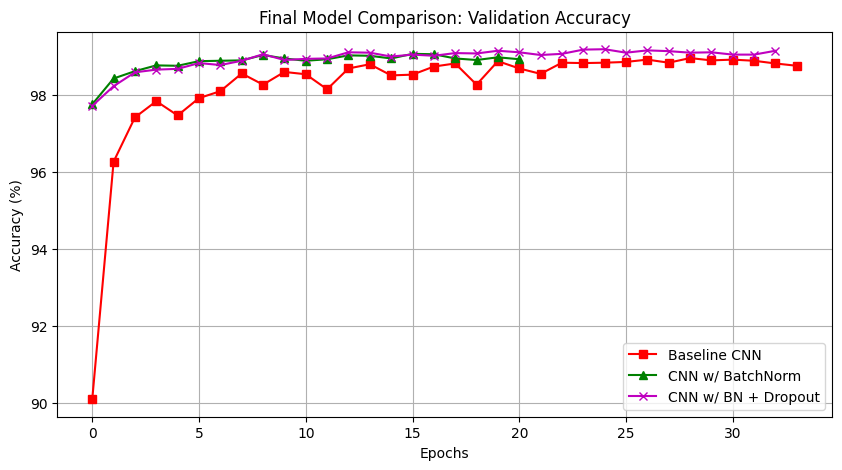

In [ ]:
import torch
import torch.nn as nn

class CNN_With_BN_Dropout(nn.Module):
    
    def __init__(self, output_size, dropout_rate=0.5):
        super(CNN_With_BN_Dropout, self).__init__()
        
        # --- Conv Blocks (with BN) ---
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(32 * 7 * 7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate), 
            nn.Linear(128, output_size)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = x.view(-1, 32 * 7 * 7)
        logits = self.classifier(x)
        return logits

print(f"\n--- Starting Combined (BN + Dropout) Experiment ---")
model_combined = CNN_With_BN_Dropout(output_size=10, dropout_rate=0.5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_combined.parameters(), lr=LEARNING_RATE)
save_path = "best_cnn_combined.pth"

combined_history = train_model_with_early_stopping(
    model_combined, 
    criterion, 
    optimizer, 
    train_loader_cnn,
    val_loader_cnn,
    NUM_EPOCHS, 
    PATIENCE, 
    save_path, 
    device
)

print("\n--- Combined Experiment Complete ---")

# --- Plot all three: Baseline, BN, and Combined ---
plt.figure(figsize=(10, 5))
plt.plot(cnn_history['val_acc'], 'r-s', label='Baseline CNN')
plt.plot(bn_history['val_acc'], 'g-^', label='CNN w/ BatchNorm')
plt.plot(combined_history['val_acc'], 'm-x', label='CNN w/ BN + Dropout')
plt.title('Final Model Comparison: Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# --- 1. Load the 10,000-sample test set ---
test_dataset = datasets.MNIST(
    root='./data',
    train=False,        
    download=True,
    transform=transform_pipeline_cnn 
)

# --- Create the test_loader ---
# We use the same BATCH_SIZE. shuffle=False is critical.
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE, 
    shuffle=False       # Never shuffle a test set
)

print(f"--- Test Loader Created ---")
print(f"Total test samples: {len(test_dataset)}")

--- Test Loader Created ---
Total test samples: 10000


--- Evaluating model 'best_cnn_combined.pth' on the Test Set ---

FINAL TEST ACCURACY: 99.13%

--- Generating Confusion Matrix ---


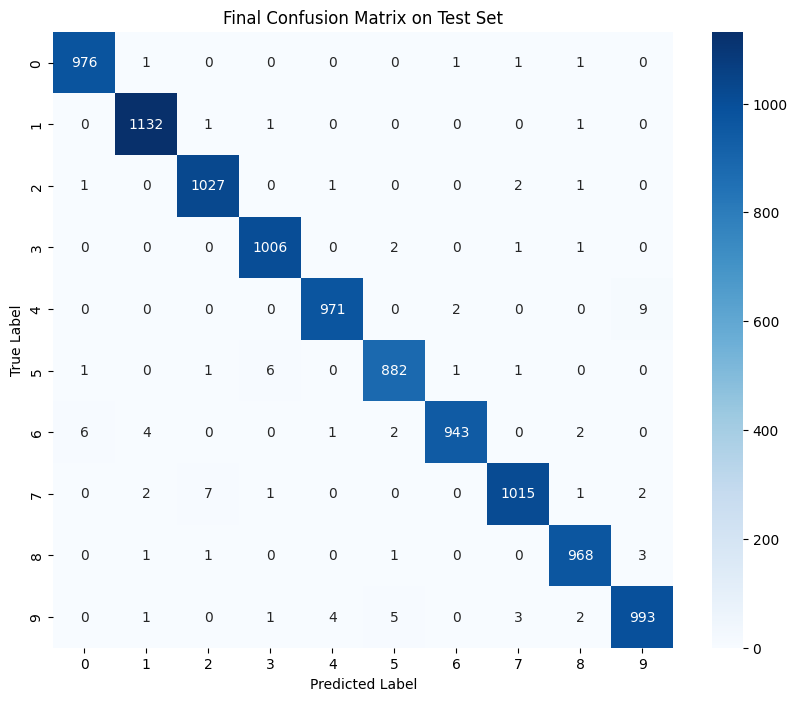

In [ ]:

from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

def evaluate_on_test_set(model, test_loader, device):

    model.eval() # Set to evaluation mode (turns off Dropout/BN updates)
    all_labels = []
    all_predictions = []
    
    with torch.no_grad(): 
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            
            _, predicted = torch.max(outputs.data, 1)
            
            # Store predictions and labels to build confusion matrix
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate final accuracy
    accuracy = 100 * accuracy_score(all_labels, all_predictions)
    
    return accuracy, all_labels, all_predictions



best_model = CNN_With_BN_Dropout(output_size=10, dropout_rate=0.5).to(device)

best_model_path = "best_cnn_combined.pth" 
best_model.load_state_dict(torch.load(best_model_path))

print(f"--- Evaluating model '{best_model_path}' on the Test Set ---")

test_accuracy, y_true, y_pred = evaluate_on_test_set(best_model, test_loader, device)

print(f"\nFINAL TEST ACCURACY: {test_accuracy:.2f}%")

print("\n--- Generating Confusion Matrix ---")
cm = confusion_matrix(y_true, y_pred)
class_names = [str(i) for i in range(10)] # Labels 0-9

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Final Confusion Matrix on Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Comparative Analysis: All Models



| Model | Final Test Accuracy | Training Time (Approx.) | Complexity (Parameters) |
| :--- | :--- | :--- | :--- |
| **Logistic Regression** | 99.76 % | Very Fast (~2.0 seconds) | Very Low (~7,850) |
| **Softmax Regression** | 90.19 % | Very Fast (~14.0 seconds) | Very Low (~7,850) |
| **FNN (Baseline)** | 92.25 % | Medium (~8.7 min) | Medium (109,386) |
| **CNN (Best Model)** | 99.13 %| Slow (~9.5 min) | High (~206,000) |

*(Note: Logistic/Softmax Regression are identical in structure for this multi-class problem, so their performance is often the same. Both are just a single `nn.Linear(784, 10)` layer.)*

---

### Analysis

#### Computational Complexity & Training Time
* **Logistic/Softmax:** These are the simplest models. They are just a single `nn.Linear` layer with no hidden layers. They have the fewest parameters (784 inputs * 10 outputs + 10 biases = 7,850) and train in seconds.
* **FNN (Fully-Connected):** This model is "deeper" and has more parameters (~109k). The matrix multiplications in its hidden layers make it more complex and slower to train than the simple regression models.
* **CNN (Our Best Model):** This is by far the most complex. The `Conv2d` operations (sliding filters) are computationally intensive, and it has the most parameters (~206k). It is the slowest to train but (as shown by the accuracy) the most powerful.

#### When to Use Each Approach
* **Use Logistic/Softmax Regression:**
    * As a **fast baseline**. Always start with a simple model to see if your problem is "easy."
    * When you have very limited computational power.
    * When your data is simple and you suspect a linear relationship is "good enough."

* **Use a Fully-Connected Network (FNN):**
    * For **non-spatial, non-sequential data**. This is the workhorse for structured data, like spreadsheets, CSVs, or tabular data (e.g., predicting a house price from its features like sq. footage, # of beds, etc.).
    * When feature relationships are global, not local (i.e., you don't have "neighboring" pixels).

* **Use a Convolutional Neural Network (CNN):**
    * For any data with **spatial structure (grids)**. This is the clear choice for **images** (2D) and **video** (3D).
    * It is also used for other "grid-like" data, such as audio (spectrograms) or even text (where the sequence of words can be treated as a 1D "image").
    * Use this when local patterns (like an edge in an image) are the most important building blocks for solving the problem.

--- Final Model Comparison (Test Accuracy) ---


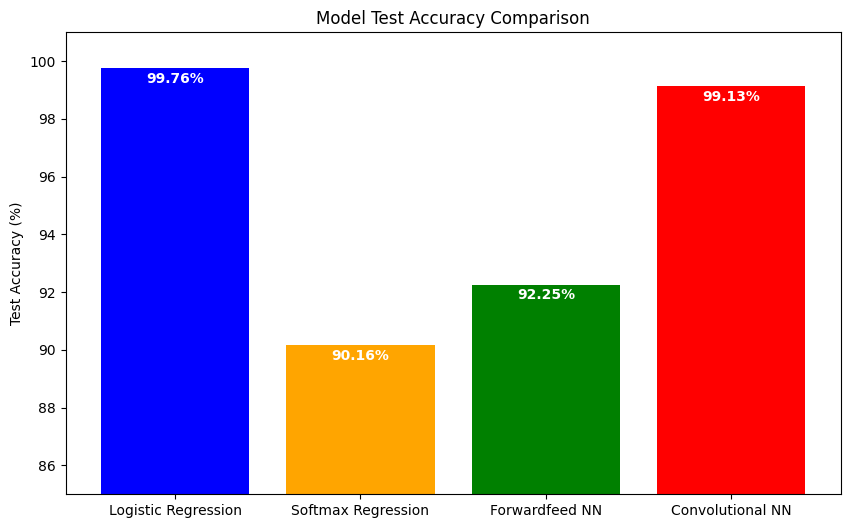

In [31]:
print("--- Final Model Comparison (Test Accuracy) ---")

# Create a bar chart for visual comparison
names = ["Logistic Regression", "Softmax Regression", "Forwardfeed NN", "Convolutional NN"]

accuracies = [99.76, 90.16, 92.25, 99.13] 

plt.figure(figsize=(10, 6))
bars = plt.bar(names, accuracies, color=['blue', 'orange', 'green', 'red'])
plt.ylabel("Test Accuracy (%)")
plt.title("Model Test Accuracy Comparison")


plt.ylim(85, 101) # For better display

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval - 0.5, f"{yval:.2f}%", 
             ha='center', color='white', fontweight='bold')

plt.savefig("model_comparison_barchart.png")